In [1]:
import math
import csv
from numpy import genfromtxt
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

C:\Users\ruban\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
XY_orig=genfromtxt('wifi_data.csv', delimiter=',')

XY_orig=np.matrix(XY_orig)          #original excel dataset
X_orig=XY_orig[1:325, 0:125].T      #eliminate feature-names, labels, unnecessary features and transpose to get X_orig
Y_orig=XY_orig[1:325, 125].T        #extract labels and transpose to get Y
X_orig_max = X_orig.max(1)          #normalizing features
X_orig=X_orig/X_orig_max

X_train=X_orig[:, 0:261]            #split into X_train
Y_train=Y_orig[:, 0:261]            #split into Y_train

X_test=X_orig[:, 261:324]           #split into X_test
Y_test=Y_orig[:, 261:324]           #split into Y_test

X_train=np.array(X_train)           #convert to array from matrices
X_test=np.array(X_test)
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

Y_train=Y_train.astype(int)         #convert to one-hot
Y_test=Y_test.astype(int)
Y_train=convert_to_one_hot(Y_train, 6)
Y_test=convert_to_one_hot(Y_test, 6)

print ("number of training examples = " + str(X_train.shape[1]))      
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 261
number of test examples = 63
X_train shape: (125, 261)
Y_train shape: (6, 261)
X_test shape: (125, 63)
Y_test shape: (6, 63)


In [3]:
def create_placeholders(n_x, n_y):

    X = tf.placeholder(tf.float32, [n_x, None])
    Y = tf.placeholder(tf.float32, [n_y, None])
    
    return X, Y

In [4]:
def initialize_parameters():
    
    tf.set_random_seed(1)               
        
    W1 = tf.get_variable("W1", [125, 125], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [125, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [125, 125], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [125, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable("W4", [6, 125], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [6, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W4": W4,
                  "b4": b4,
                 }
    
    return parameters


In [5]:
def forward_propagation(X, parameters):
    
    # Retrieve the parameters from the dictionary 'parameters' 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.relu(Z1)                                                            
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                             
    A2 = tf.nn.relu(Z2)                                                            
    Z4 = tf.add(tf.matmul(W4, A2), b4) 
    
    return Z4


In [6]:
def compute_cost(Z4, Y):
    
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [7]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1700, minibatch_size = 261, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z4 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z4, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                           # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        print()

        # Calculate accuracies
        #Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        print()
        
        return parameters
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Cost after epoch 0: 1.834809
Cost after epoch 100: 1.224592
Cost after epoch 200: 0.976553
Cost after epoch 300: 0.864540
Cost after epoch 400: 0.787644
Cost after epoch 500: 0.725365
Cost after epoch 600: 0.671331
Cost after epoch 700: 0.619880
Cost after epoch 800: 0.571936
Cost after epoch 900: 0.527309
Cost after epoch 1000: 0.486025
Cost after epoch 1100: 0.448624
Cost after epoch 1200: 0.414935
Cost after epoch 1300: 0.385919
Cost after epoch 1400: 0.361411
Cost after epoch 1500: 0.340887
Cost after epoch 1600: 0.323392


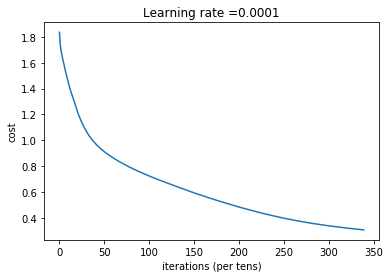

Parameters have been trained!

Train Accuracy: 0.8659004
Test Accuracy: 0.85714287



In [8]:
parameters = model(X_train, Y_train, X_test, Y_test)
